# Case Study: Image Classification with Optimization, Regularization,and Hyperparameter Tuning using CIFAR-10

## Objective

This project focuses on building an effective image classification model using the CIFAR-10 dataset. We will apply various deep learning techniques such as optimization algorithms, regularization methods, and hyperparameter tuning to improve performance. The goal is to have hands-on experience in applying these concepts to a real-world problem.

## Dataset Overview

The CIFAR-10 dataset is a well-known dataset for image classification tasks. It contains:

- 60,000 color images of size 32x32 pixels.

- The dataset is divided into 10 classes, with each class containing 6,000 images. The classes are:

1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

- **Training Set:** 50,000 images
- **Test Set:** 10,000 images



## Exploratory Data Analysis (EDA)

### Step 1: Importing Libraries and Dataset

Let's start by importing the necessary libraries and loading the CIFAR-10 dataset directly from TensorFlow.

In [70]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dropout, BatchNormalization, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Define class names for CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print("Training data shape:", train_images.shape)
print("Testing data shape:", test_images.shape)

Training data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)


### Step 2: Visualizing Feature Distributions

In [71]:
# Check the shapes of train and test datasets
print("Training labels shape:", train_labels.shape)
print("Testing labels shape:", test_labels.shape)

Training labels shape: (50000, 1)
Testing labels shape: (10000, 1)


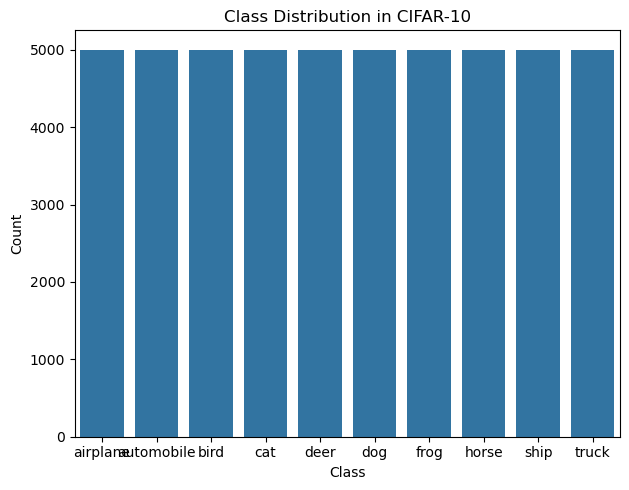

In [72]:
# Plot class distribution to ensure balanced data
# Count unique labels in training set
unique, counts = np.unique(train_labels, return_counts=True)

# Plotting the class distribution
plt.figure(figsize=(12, 5))

# Plotting the class distribution
plt.subplot(1, 2, 1)

sns.barplot(x=unique, y=counts)
plt.xticks(ticks=np.arange(10), labels=class_names)
plt.title("Class Distribution in CIFAR-10")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Step 3: Sample Image Visualization
Visualizing some images from the dataset.

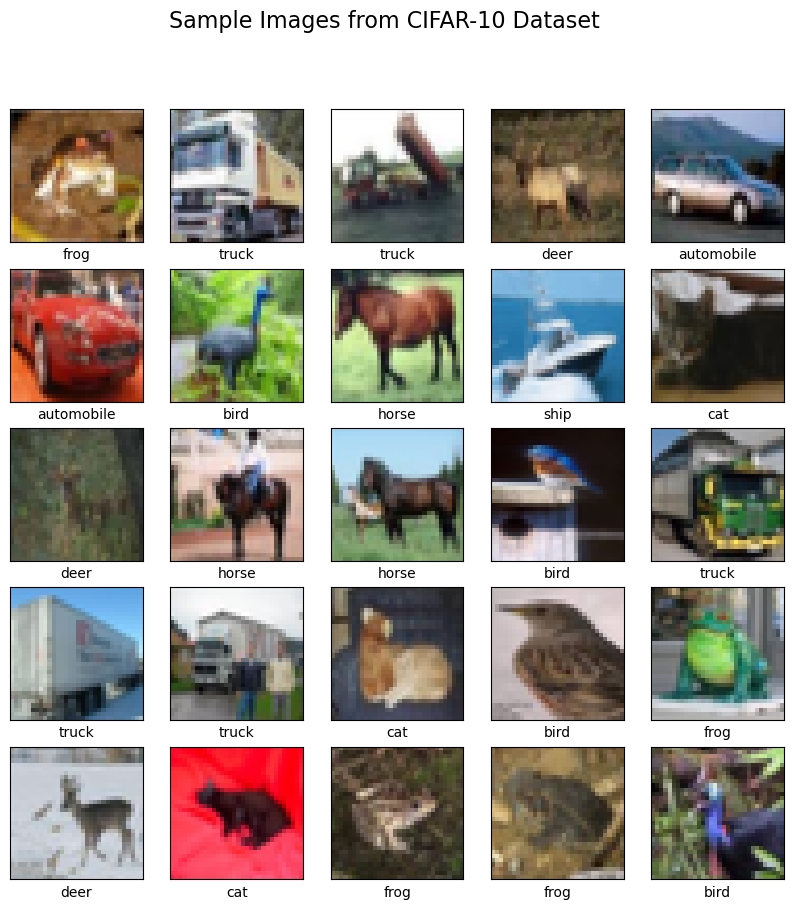

In [73]:
# Display sample images from CIFAR-10 dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.suptitle("Sample Images from CIFAR-10 Dataset", fontsize=16)
plt.show()

The code shows 25 sample images from the CIFAR-10 dataset, highlighting the variety within its 10 classes, which include both vehicles and animals. This quick visualization helps confirm that the labels match the images and that the image quality is sufficient. By examining the dataset visually, we get an early sense of its content, which can guide our model design and training approach.

### Step 4: Pixel Value Distribution

Understanding the pixel values helps us determine the need for normalization.

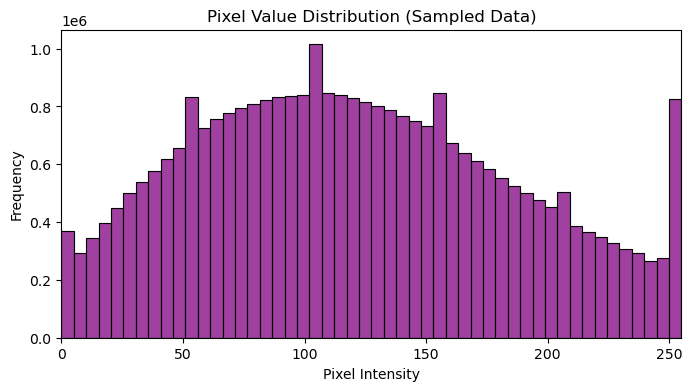

In [74]:
# Take the first 10,000 training images to reduce memory and speed up plotting
sample_size = 10000

# Flatten the images to create a 1D array of pixel values
pixel_values = train_images[:sample_size].astype('float32').ravel()

# Plot histogram of pixel intensity distribution
plt.figure(figsize=(8, 4))
sns.histplot(pixel_values, bins=50, color='purple')  # 50 bins for smoother distribution
plt.title("Pixel Value Distribution (Sampled Data)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# Restricts the x-axis to valid pixel intensity values (0–255)
plt.xlim(0, 255)  # Pixel values range from 0 (black) to 255 (white)
plt.show()


Understanding the pixel values helps us determine the need for normalization.

## Feature Engineering

Feature Engineering improves the quality of the dataset, making it easier for the model to generalize well.

### Step 1: Normalization

Normalize pixel values from [0, 255] to [0, 1] . This helps the model train faster and improves numerical stability

In [75]:
train_images = train_images / 255.0
test_images = test_images / 255.0

### Step 2: Data Augmentation

Applying data augmentation (shifting, flipping, zooming) helps reduce overfitting.

In [76]:
# Create an image data generator for augmentation during training.
# These transformations help the model generalize better by showing it
# slightly varied versions of the same image on each epoch.

# Set up data augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,   # Randomly shift the image horizontally by up to 10% of the width
    height_shift_range=0.1,  # Randomly shift the image vertically by up to 10% of the height
    horizontal_flip=True,    # Randomly flip images horizontally left-to-right
    zoom_range=0.1           # Randomly zoom in or out by up to 10%
)


# Prepare the generator using the training images
# (needed if using feature-wise normalization or ZCA whitening)
datagen.fit(train_images)


## Building and Optimizing the Model

Constructing a Convolutional Neural Network (CNN) and incorporating optimizers, momentum, and learning rate schedules to optimize training.

### Step 1: Model Architecture

In [77]:
model = Sequential([

    # --- First Convolutional Block ---
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),  # Conv layer: 32 filters, 3x3 kernel
    BatchNormalization(),                                            # Normalize activations for stability
    Conv2D(32, (3, 3), activation='relu'),                           # Another conv layer for more features
    MaxPooling2D(pool_size=(2, 2)),                                  # Downsample feature maps (reduce size)
    Dropout(0.2),                                                    # Drop 20% neurons (regularization)

    # --- Second Convolutional Block ---
    Conv2D(64, (3, 3), activation='relu'),                           # Conv layer: 64 filters, 3x3 kernel
    BatchNormalization(),                                            # Normalize activations
    Conv2D(64, (3, 3), activation='relu'),                           # Another conv for deeper feature learning
    MaxPooling2D(pool_size=(2, 2)),                                  # Further downsampling
    Dropout(0.3),                                                    # Drop 30% neurons

    # --- Fully Connected Layers ---
    Flatten(),                                                      # Flatten 2D feature maps to 1D vector
    Dense(128, activation='relu'),                                  # Fully connected layer (128 neurons)
    BatchNormalization(),                                           # Normalize dense layer activations
    Dropout(0.4),                                                   # Drop 40% neurons
    Dense(10, activation='softmax')                                 # Output layer (10 classes, softmax)
    # softmax output layer for multi-class classification
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Step 2: Applying Optimizers and Learning Rate Schedules

In [78]:
# Define a custom learning rate schedule function
# - Keep LR constant for first 10 epochs (warm-up)
# - Then decay LR exponentially by factor e^(-0.1) each epoch

import tensorflow as tf
import math

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)
    
        

# Compile the model
# - Adam optimizer for adaptive learning rates
# - Sparse categorical crossentropy for integer class labels
# - Track accuracy as evaluation metric
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Create a learning rate scheduler callback that applies lr_schedule each epoch
lr_callback = LearningRateScheduler(lr_schedule)

### Step 3: Training the Model with Regularization

We use Dropout, Batch Normalization, and Early Stopping to prevent overfitting and improve generalization.

In [79]:
# Train the model using real-time data augmentation
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),  # Augmented batches of 64 images
    epochs=20,                                                # Train for 20 full passes over the dataset
    validation_data=(test_images, test_labels),               # Evaluate on test set after each epoch
    callbacks=[lr_callback]                                   # Apply learning rate schedule each epoch
)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 106s 131ms/step - accuracy: 0.4100 - loss: 1.6648 - val_accuracy: 0.5495 - val_loss: 1.2379 - learning_rate: 0.0010
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 104s 133ms/step - accuracy: 0.5519 - loss: 1.2555 - val_accuracy: 0.5419 - val_loss: 1.4174 - learning_rate: 0.0010
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 119s 153ms/step - accuracy: 0.6125 - loss: 1.0965 - val_accuracy: 0.6711 - val_loss: 0.9259 - learning_rate: 0.0010
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 125s 160ms/step - accuracy: 0.6433 - loss: 1.0100 - val_accuracy: 0.6151 - val_loss: 1.1516 - learning_rate: 0.0010
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 118s 151ms/step - accuracy: 0.6683 - loss: 0.9538 - val_accuracy: 0.6695 - val_loss: 0.9667 - learning_rate: 0.0010
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 120s 153ms/step - accuracy: 0.6821 - loss: 0.9114 - val_accuracy: 0.7018 - val_loss: 0.8663 - learning_rate: 0.0010
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 126s 161ms/step - accuracy: 0.6950 

## Visualizing Training History

Visualizing the training and validation loss and accuracy helps us understand how well the model is performing over epochs.

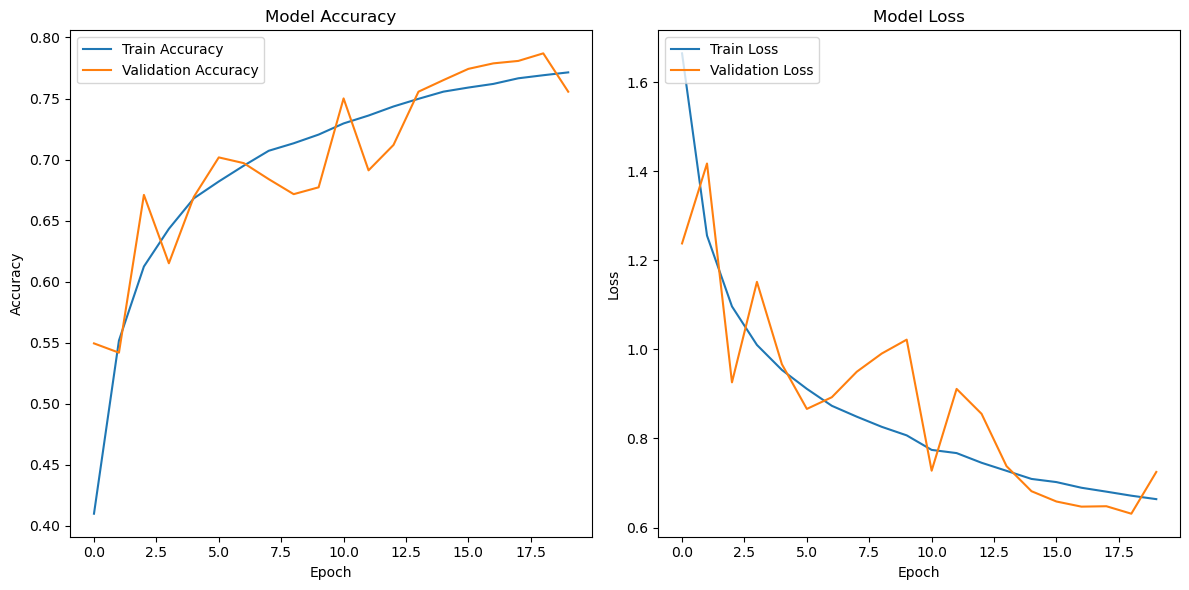

In [80]:
# Plot training vs validation accuracy and loss over epochs
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


### Hyperparameter Tuning

Using random search, we tune batch size, learning rate, and the number of epochs to find the best settings. This step can be expanded into a separate function to systematically explore hyperparameters.

#### Example of Hyperparameter Tuning: Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

# Note: Custom function may be needed to adapt for Keras with GridSearchCV.
# This is a simplified example for illustration.

## Model Evaluation

Finally, we evaluate the model on the test data to measure its accuracy.

In [81]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7556 - loss: 0.7248
Test Accuracy: 75.56%


## Conclusion

- In this case study, we tackled the task of classifying images from the CIFAR-10 dataset — a common benchmark in deep learning. Along the way, we applied and connected key concepts needed to build effective neural networks.

- We began by understanding the dataset, which consists of colorful images representing ten different classes, and conducted exploratory data analysis (EDA) to gain insights into the data distribution. This step helped us identify potential issues and informed our preprocessing strategies.

- Next, we implemented feature engineering techniques, such as normalization and data augmentation, to enhance the quality of our input data. These techniques help the model adapt better to generalize to unseen data, thus reducing the risk of overfitting.

- For the model, we built a Convolutional Neural Network (CNN) and experimented with optimization strategies such as the Adam optimizer and dynamic learning rates. We also applied regularization methods like dropout and batch normalization to keep training stable and prevent overfitting.

- We monitored training progress through accuracy and loss plots, using them not just as evaluation tools but also as feedback for refining our approach.

- Overall, this project demonstrated how each stage — from dataset understanding to tuning and evaluation — plays an essential role in developing a strong image classification model.

- By completing this case study, I’ve strengthened my grasp of deep learning fundamentals and is better prepared for more advanced, real-world challenges. Let’s keep exploring, testing, and learning!